In [31]:
!pip install pyspark graphframes awkward pyarrow networkx matplotlib

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('graphframes_pagerank') \
                    .config("spark.driver.memory","16g") \
                    .config("spark.jars.packages","graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
                    .config("spark.jars.excludes","org.slf4j:slf4j-api") \
                    .getOrCreate()

22/11/26 08:21:19 WARN Utils: Your hostname, sigmac-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.159 instead (on interface en0)
22/11/26 08:21:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/opt/homebrew/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/sigmar/.ivy2/cache
The jars for the packages stored in: /Users/sigmar/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3ae921f2-53b5-4bcd-ac09-fd66c6a7c33d;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
:: resolution report :: resolve 97ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-3ae921f

22/11/26 08:21:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import IntegerType
from graphframes.examples import Graphs
g = Graphs(spark).friends()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [68]:
from graphframes import GraphFrame
vertices = spark.read.format("csv").load("/Users/sigmar/vertedges/vert_gs.csv") \
    .withColumnRenamed("_c0","id") \
    .withColumnRenamed("_c1","name") \
    .withColumnRenamed("_c2","presentIn") \
    .withColumnRenamed("_c3","color");
edges = spark.read.format("csv").load("/Users/sigmar/vertedges/edge_gs.csv").withColumnRenamed("_c0","src").withColumnRenamed("_c1","dst")
g = GraphFrame(vertices, edges).dropIsolatedVertices()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [65]:
g.inDegrees.orderBy(col("inDegree").desc()).toPandas()

,id,inDegree
0,WP_143584933.1,78
1,WP_014632315.1,62
2,WP_126177392.1,58
3,extdb:filiformis947_002254,35
4,extdb:thermophilus791_000641,23
...,...,...
2988,extdb:arciformis4241_001595,2
2989,WP_126165250.1,2
2990,WP_135260046.1,2
2991,extdb:scotoductus346_000810,1


In [69]:
labpropres = g.labelPropagation(maxIter=100)

In [85]:
sortlabprop = labpropres.orderBy(col("label"))
sortlabprop.where("name like '%WYL%'").toPandas()

,id,name,presentIn,color,label
0,TTJL18_RS10625,WYL domain-containing protein,1,#00aa00,438086664195
1,WP_024118773.1,WYL domain-containing protein,4,#00aa00,438086664195
2,WP_015717149.1,WYL domain-containing protein,4,#00aa00,798863917068


In [80]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
pds = sortlabprop.groupBy("label").count().orderBy(col("count").desc()).toPandas()
pds

,label,count
0,395136991232,220
1,644245094404,181
2,558345748491,177
3,833223655434,168
4,893353197578,74
...,...,...
305,360777252872,1
306,386547056649,1
307,446676598790,1
308,481036337159,1


In [86]:
sortlabprop.where("label = 438086664195").toPandas()

,id,name,presentIn,color,label
0,WP_014511103.1,hypothetical protein,5,#00aa00,438086664195
1,WP_028490815.1,Cas1,5,#00aa00,438086664195
2,WP_024118773.1,WYL domain-containing protein,4,#00aa00,438086664195
3,WP_126218928.1,hypothetical protein,1,#00aa00,438086664195
4,TTJL18_RS10625,WYL domain-containing protein,1,#00aa00,438086664195
5,WP_014511102.1,hypothetical protein,2,#00aa00,438086664195
6,WP_124105757.1,hypothetical protein,5,#00aa00,438086664195
7,WP_038044033.1,Cas4,5,#00aa00,438086664195


In [41]:
spaths = g.shortestPaths()

TypeError: GraphFrame.shortestPaths() missing 1 required positional argument: 'landmarks'

In [31]:
spark.sparkContext.setCheckpointDir("/Users/sigmar/checkpoint")
res = g2.connectedComponents()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [89]:
stronglyConnectedComponents = g.stronglyConnectedComponents(maxIter=100)
stronglyConnectedComponents.orderBy(col("component").desc()).toPandas()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,id,name,presentIn,color,component
0,WP_014511309.1,ABC transporter permease,1,#00aa00,0
1,WP_014511308.1,ABC transporter permease,1,#00aa00,0
2,WP_041445125.1,hypothetical protein,1,#00aa00,0
3,WP_014511307.1,ABC transporter substrate-binding protein,1,#00aa00,0
4,WP_014511313.1,hydantoinase/oxoprolinase family protein,1,#00aa00,0
...,...,...,...,...,...
2988,CSW46_RS05590,tRNA-Met,7,#aa0000,0
2989,scotoductus2121_000106,tRNA-Lys,7,#aa0000,0
2990,BLP62_RS13090,16S ribosomal RNA,7,#aa0000,0
2991,CSW41_RS07000,tRNA-Trp,7,#aa0000,0


In [90]:
#g3 = g2.dropIsolatedVertices()
connectedComponents = g.connectedComponents()
connectedComponents.orderBy(col("component").desc()).where("component>0").toPandas()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,id,name,presentIn,color,component


22/11/26 21:58:29 WARN AsyncEventQueue: Dropped 703 events from appStatus since Sat Nov 26 18:20:33 GMT 2022.
22/11/26 23:05:00 WARN AsyncEventQueue: Dropped 27 events from appStatus since Sat Nov 26 21:58:29 GMT 2022.


In [38]:
res.orderBy(col("component").desc()).where("component>0").toPandas()

,id,name,_c2,component
0,WP_207776980.1,hypothetical protein,#00aa00,1236950581259
1,WP_016036071.1,DUF3110 domain-containing protein,#00aa00,1228360646661
2,WP_207776989.1,2OG-FeII oxygenase,#00aa00,1185410973715
3,WP_207776992.1,hypothetical protein,#00aa00,1082331758606
4,WP_016036019.1,AbrB/MazE/SpoVT family DNA-bindingdomain-conta...,#00aa00,927712935940
5,WP_207776968.1,hypothetical protein,#00aa00,919123001358
6,WP_165740456.1,DNA adenine methylase,#00aa00,893353197576
7,WP_165740433.1,hypothetical protein,#00aa00,652835029002
8,WP_207776952.1,hypothetical protein,#00aa00,652835029002
9,WP_207776970.1,hypothetical protein,#00aa00,601295421450


In [10]:
triResult = g2.triangleCount()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [15]:
triResult.orderBy(col("count").desc()).where("count > 0").toPandas()

,count,id,name,_c2
0,22,WP_028493941.1,transposase,#00aa00
1,19,BS74_RS11975,transposase,#aa0000
2,15,WP_143587230.1,IS256 family transposase,#aa0000
3,10,WP_203970727.1,transposase,#00aa00
4,9,QT17_RS13625,transposase,#00aa00
...,...,...,...,...
546,1,WP_126170279.1,CTP synthase,#00aa00
547,1,islandicus3838_000463,AhpC/TSA family protein,#00aa00
548,1,extdb:scotoductus346_000158,sulfite oxidase-like oxidoreductase,#aa0000
549,1,WP_015716774.1,ATP synthase subunit C,#aa0000


In [4]:
prResult = g2.pageRank(tol=0.01) #.resetProbability(0.15).tol(0.01).run()

22/11/26 08:21:59 WARN BlockManager: Block rdd_112_0 already exists on this machine; not re-adding it


/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [8]:
prResult.vertices.select("name", "pagerank").orderBy(col("pagerank").desc()).toPandas()

,name,pagerank
0,transposase,14.262950
1,transposase,14.200332
2,IS256 family transposase,11.889252
3,IS200/IS605 family element transposase accesso...,6.911462
4,transposase,5.896750
...,...,...
2985,hypothetical protein,0.160372
2986,hypothetical protein,0.160372
2987,DNA adenine methylase,0.160372
2988,hypothetical protein,0.160372


In [9]:
prResult.edges.select("src", "dst", "weight").toPandas()

,src,dst,weight
0,WP_039459555.1,FJR75_RS07735,0.250000
1,WP_126177718.1,TT_RS02875,0.333333
2,WP_203972024.1,TT_RS02875,0.333333
3,WP_011174019.1,WP_014628843.1,0.500000
4,WP_126204373.1,WP_014628843.1,0.500000
...,...,...,...
7686,WP_126178013.1,extdb:scotoductus346_000158,0.500000
7687,WP_126164537.1,extdb:scotoductus346_000604,0.500000
7688,WP_014515162.1,extdb:scotoductus346_000604,0.500000
7689,WP_143591886.1,islandicus3838_000463,0.500000


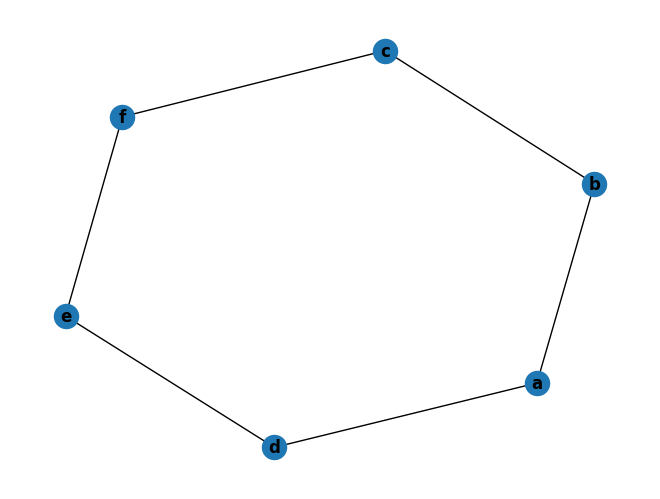

In [15]:
import networkx as nx

def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    #plt.subplot(121)
    nx.draw(Gplot, with_labels=True, font_weight='bold')

PlotGraph(g.edges)

In [7]:
display(g2)

GraphFrame(v:[id: string, _c1: string ... 1 more field], e:[src: string, dst: string ... 1 more field])

In [23]:
g.vertices.toPandas().to_csv("vertices.csv", index=False)
g.vertices.toPandas()

,id,name,age
0,a,Alice,34
1,b,Bob,36
2,c,Charlie,30
3,d,David,29
4,e,Esther,32
5,f,Fanny,36


In [24]:
g.edges.toPandas().to_csv("edges.csv", index=False)
g.edges.toPandas()

,src,dst,relationship
0,a,b,friend
1,b,c,follow
2,c,b,follow
3,f,c,follow
4,e,f,follow
5,e,d,friend
6,d,a,friend


In [ ]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.toPandas()

In [ ]:
motifs.filter("b.age > 30").toPandas()

In [ ]:
results = g.triangleCount()
results.select("id", "count").toPandas()

In [ ]:
results = g.shortestPaths(landmarks=["a", "d"])
results.select("id", "distances").toPandas()

In [2]:
import awkward as ak
import polars as pl
import numpy as np
import pyarrow as pa
import time

#def ff(x):
#    print("hey")
#    print(x)
#    return x

def test_func(iterator):
    onehot = {"a":[0,0], "g":[0,1], "c":[1,0], "t":[1,1]}
    for batch in iterator:
        #plrs = pl.from_records(batch)
        #flat_list = [[item for item in [onehot[y] for y in x]] for x in batch["_c1"]]
        flat_list = [[o for k in sublist for o in onehot[k]] for sublist in batch["sequence"]]
        #for sublist in batch["_c1"]:
        #    l = [o for k in sublist for o in onehot[k]]
            #for item in sublist:
            #    for k in onehot[item]:
            #        l.append(k)
        #    flat_list.append(l)
        #flat_list = [item for sublist in l for item in sublist]
        batch["sequence"] = flat_list
        yield batch
        #str = batch["_c1"]
        #print(type(str))
        #nstr = len(str)
        #parr = pa.array(range(len(str)))
        #for c in str:
        #    buf = c.as_buffer()
        #    parr.append(c)
            #print(buf.size)
        #b = ak.from_arrow(batch)
        #np.char.cb["_c1"]
        #np.char.replace(b["_c1"],"\n","")
        #b2 = ak.Array({"c0": b["_c0"], "c1": b["_c1"]})
        #b2 = ak.zip({"_c1": b["_c1"]}, depth_limit=1)
        #for k in batch:
        #    k[1]
            #    print(s)
            #np.char.replace(k[1],"a","")
        #bleh = pa.array(parr)
        #yield pa.RecordBatch.from_arrays([batch["_c0"], bleh], names=["erm","term"])

In [63]:
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql.functions import ascii
from pyspark.ml.functions import array_to_vector
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorIndexer
import pyspark.sql.types as T

df = spark.read.format("csv").option("lineSep",">").option("delimiter"," ").load("/Users/sigmar/cov19_variants3.fasta")
df = df.withColumnRenamed("_c0","name")
df = df.withColumnRenamed("_c1","sequence")
df.toPandas()

""


In [3]:
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql.functions import ascii
from pyspark.sql.functions import col
from pyspark.ml.functions import array_to_vector
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import PCA
import pyspark.sql.types as T

df = spark.read.format("csv").option("lineSep",">").option("delimiter"," ").load("/Users/sigmar/cov19_variants3.fasta")
df = df.withColumnRenamed("_c0","name")
df = df.withColumnRenamed("_c1","sequence")
df = df.withColumn("sequence", expr("regexp_replace(sequence,'\n','')"))
#df = df.withColumn("_c1", split(col("_c1"),""))
ddl_schema_string = "name string,sequence array<int>"
nschema = T._parse_datatype_string(ddl_schema_string)
df = df.mapInPandas(test_func, nschema)
df = df.withColumn("sequence", array_to_vector(col("sequence")))

#indexer = VectorIndexer(inputCol="_c1", outputCol="indexed", maxCategories=10)
#indexerModel = indexer.fit(df)

#indexedData = indexerModel.transform(df)
#indexedData.show()

#ohe = OneHotEncoder()
#ohe.setInputCols(["_c1"])
#ohe.setOutputCols(["output"])
#model = ohe.fit(df)
#model.setOutputCols(["output"])
#df2 = model.transform(df)
#df2.head().output
#df.toPandas()

In [6]:
pca = PCA(k=3, inputCol="sequence")
model = pca.fit(df)
model.setOutputCol("output")
stuff = model.transform(df).select("name","output").toPandas()

In [10]:
stuff.to_csv("/Users/sigmar/cov19_pca.csv", index=False, sep="\t")

22/11/24 15:11:28 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1009475 ms exceeds timeout 120000 ms
22/11/24 15:11:28 WARN SparkContext: Killing executors is not supported by current scheduler.
22/11/24 16:45:55 WARN TransportChannelHandler: Exception in connection from /192.168.1.159:49464
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:339)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:293)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:268)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.chan